# Wine Review Analysis: Worldwide & France

**Data: **  

[Source of Data](https://www.kaggle.com/zynicide/wine-reviews)
Dimension:  10 columns and 150k rows of wine reviews.

**Context:**

The data was scraped from WineEnthusiast on November 22nd, 2017 by [zackthoutt](https://www.kaggle.com/zynicide).
WineEnthusiast collect wine reviews from a team of experienced wine taster, the dataset represent a set of wine reviews with ratings and description of the wine tasted.

**Goal: **

Exploratory Analysis of wines: 
- Distributions.
- Influence of wine ratings over prices.
- Most expensive variety.
- Best variety rating.

Country: The country that the wine is from description

designation: The vineyard within the winery where the grapes that made the wine are from

points: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)

price: The cost for a bottle of the wine

province: The province or state that the wine is from

region_1: The wine growing area in a province or state (ie Napa)

region_2: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank

variety: The type of grapes used to make the wine (ie Pinot Noir)

winery: The winery that made the wine

## Table of Contents:
- [1) Overall Exploration](#1)
    - [1.1) TOP3 variety by country](#1.1)
    - [1.2) Price distribution](#1.2)
    - [1.3) Points distribution](#1.3)
    - [1.4) Influence of Wine Ratings over Price](#1.4)
    - [1.5) Most expensive variety](#1.5)
    - [1.6) Wineries with the biggest number of unique wines](#1.6)
- [2) Zoom on the vineyard of France](#2)
    - [2.1) Which variety is the most expensive ?](#2.1)
    - [2.2) Which variety has the best ratings for the most frequent variety ?](#2.2)
    - [2.3) Wineries with the biggest number of unique wines](#2.3)

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import missingno as msno

import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Customize Matplotlib
mpl.rcParams['font.size'] = 14
mpl.rcParams["figure.figsize"] = (10,8)

In [2]:
df = pd.read_csv('../input/winemag-data_first150k.csv',index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


 <a id="1"></a>
# 1) Overall Exploration

### Visualize nullity by column

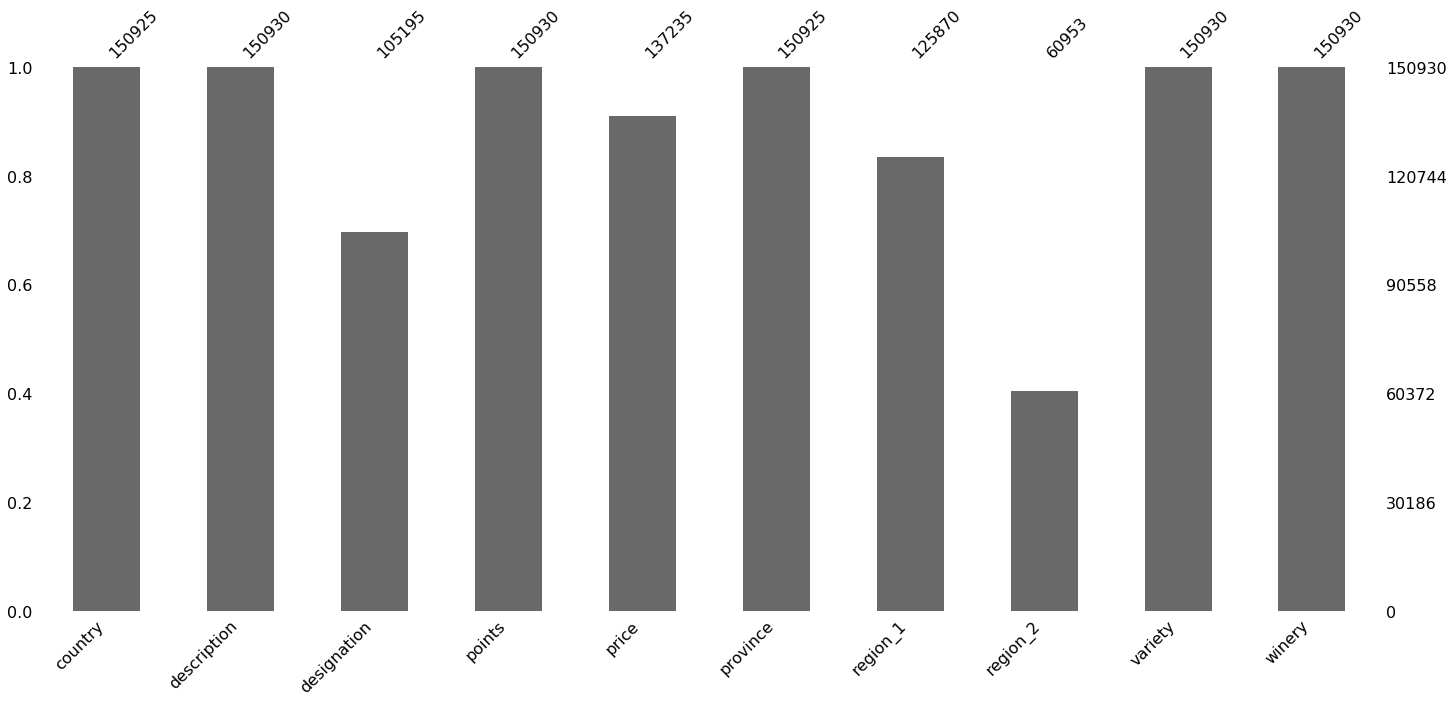

In [4]:
msno.bar(df)

### Country Distribution

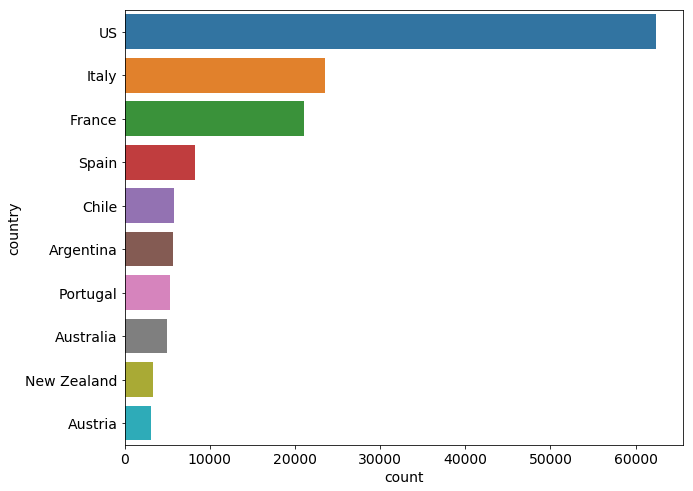

In [23]:
sns.countplot(y="country", data=df, order=df.country.value_counts().iloc[:10].index)
plt.show()

### Variety Distribution

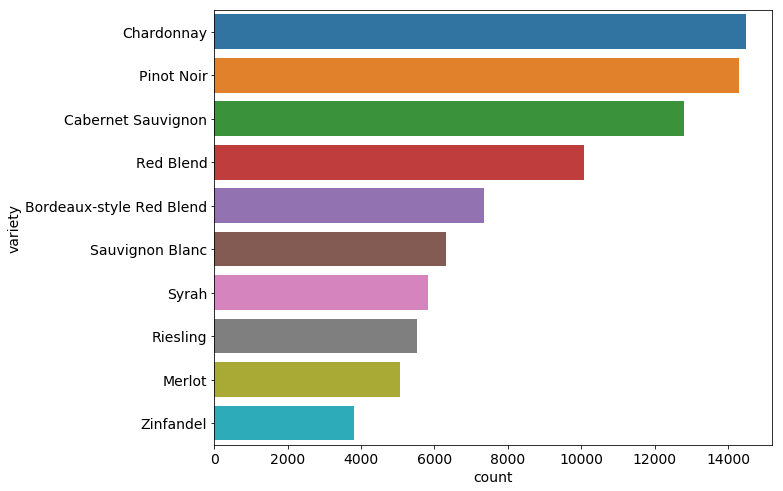

In [24]:
sns.countplot(y="variety", data=df, order=df.variety.value_counts().iloc[:10].index)
plt.show()

 <a id="1.1"></a>
### TOP3 Variety by Country

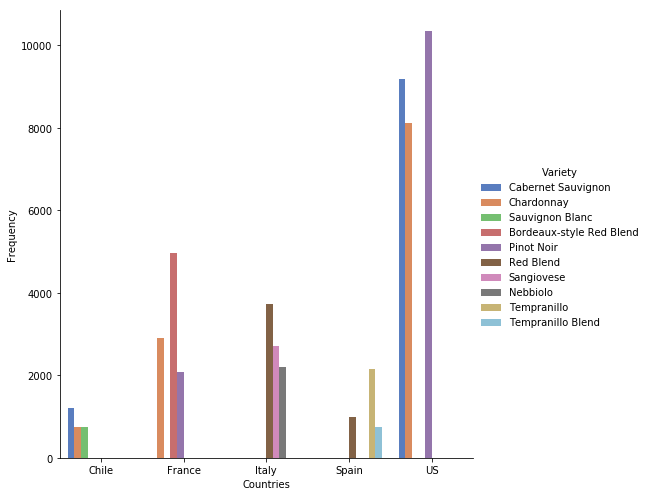

In [7]:
groupby_variety = df.groupby(["country", "variety"])["variety"].count()

top_variety = groupby_variety.groupby(level=0, group_keys=False)
top3_variety = top_variety.nlargest(3)

df_top3_variety = top3_variety.loc[["US", "Italy", "France", "Spain","Chile"],:].to_frame()

df_top3_variety.columns = ["Frequency"]
df_top3_variety.index.names = ['Countries','Variety']
df_top3_variety.reset_index(inplace=True)

sns.catplot(x="Countries", y="Frequency", hue="Variety", data=df_top3_variety,
                height=7, kind="bar", palette="muted")

 <a id="1.2"></a>
### Price Distribution 

Percentage of NaN Price: 0.09


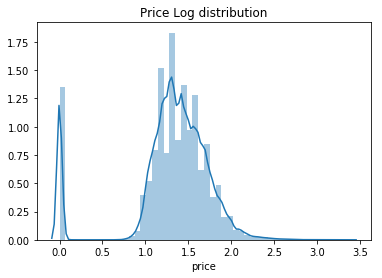

In [8]:
percentage_NaN_price = round(df.price.isnull().sum() / df.shape[0], 2)
print("Percentage of NaN Price: {}".format(percentage_NaN_price))

df.price.fillna(0, inplace=True)

ax = sns.distplot(np.log10(df.price + 1))
plt.title("Price Log distribution")
plt.show()

The majority of wine prices are between 10 and 100$(logarithm base 10).

 <a id="1.3"></a>
### Points Distribution

In [9]:
df.points.describe()

count    150930.000000
mean         87.888418
std           3.222392
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

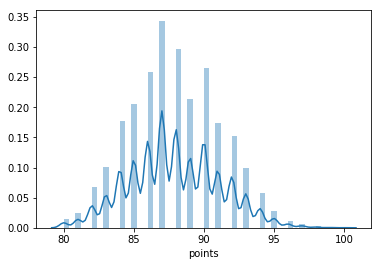

In [10]:
ax = sns.distplot(df.points)
plt.show()

WineEnthusiast only post wines with a range >= 80.
The following scale rating is used:
* 95-100 Classic: a great wine
* 90-94 Outstanding: a wine of superior character and style
* 85-89 Very good: a wine with special qualities
* 80-84 Good: a solid, well-made wine

Wine reviews are based on blind tastings. Different editors cover the same region year to year.
This rating is not a famous one, like Robert Parker or Revue du Vin de France.


50% of wine reviews are between 86-90 points. As we could imagine there is very small number of great wines >= 95.

In [11]:
points_percentage = df.points.value_counts(normalize=True) * 100
great_wines_percentage = round(points_percentage.loc[95:100].sum(), 2)
print("Proportion of great Wines>= 95: {}".format(great_wines_percentage))

Proportion of great Wines>= 95: 3.57


 <a id="1.4"></a>
## Influence of Wine Ratings over Price

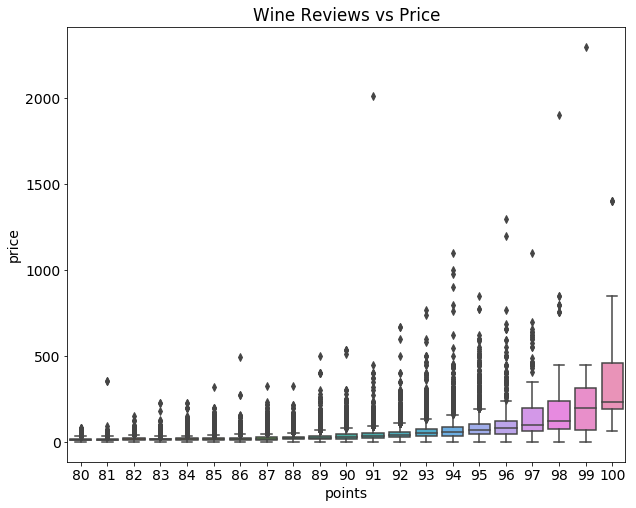

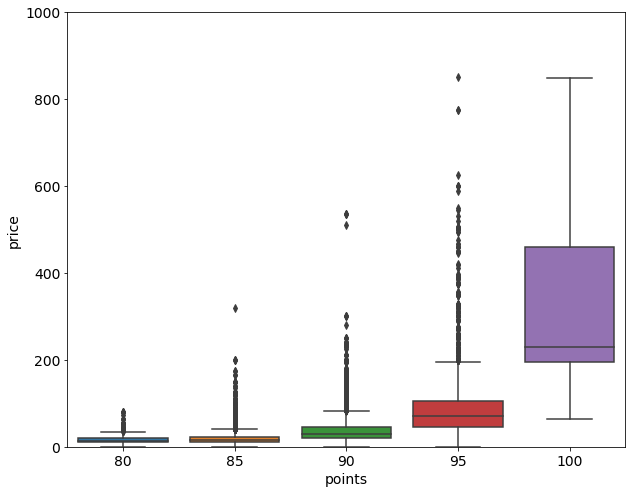

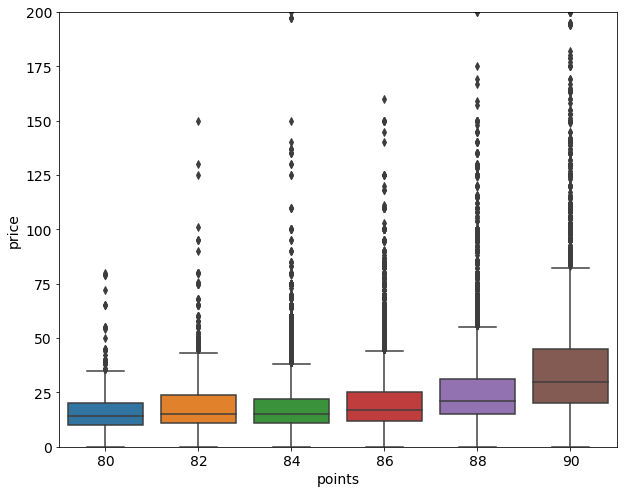

In [25]:
ax = sns.boxplot(x="points", y="price", data=df)
plt.title("Wine Reviews vs Price")
plt.show()

subset_ratings_step5 = df.loc[df.points.isin([80, 85, 90, 95, 100]), ["price","points"]]
ax = sns.boxplot(x="points", y="price", data=subset_ratings_step5)
plt.ylim([0,1000])
plt.show()

subset_ratings_step2 = df.loc[df.points.isin([80, 82, 84, 86, 88, 90]), ["price","points"]]
ax = sns.boxplot(x="points", y="price", data=subset_ratings_step2)
plt.ylim([0,200])
plt.show()

We don't see a clear influence of low ratings <= 88 over prices, whereas high ratings influence clearly price.

Let's do an ANOVA Test to find relationships between ratings and prices.

ANOVA will find if there is a real difference between price means and ratings by testing if there is a significant difference between ratings.

In [13]:
#ANOVA
model = smf.ols(formula='points ~ price', data=df)
results = model.fit()
print("The ANOVA Test find a significant difference between these 2 variables. \n"
      "F-statistic: {} F-pvalue: {}".format(results.fvalue, results.f_pvalue))

The ANOVA Test find a significant difference between these 2 variables. 
F-statistic: 28167.758351969973 F-pvalue: 0.0


 <a id="1.5"></a>
 ## Most expensive variety

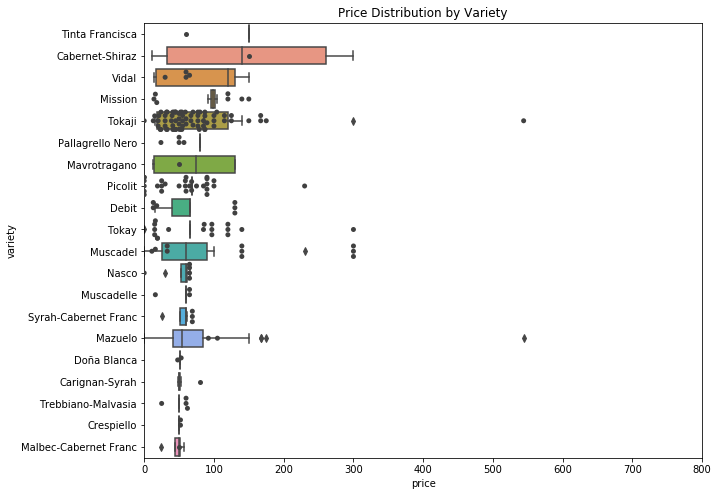

In [14]:
median_top20_variety = df.loc[:, ["variety", "price"]] \
         .groupby("variety") \
         .median() \
         .sort_values(by="price", ascending= False)  \
         .index[:20] \
         .values
plt.figure(figsize=(10,8))
ax = sns.boxplot(x="price", y="variety",
                 data=df.loc[df["variety"].isin(median_top20_variety),:],
                 order=median_top20_variety
                )
ax = sns.swarmplot(x="price", y="variety", 
                   data=df.loc[df["variety"].isin(median_top20_variety),:],
                   color=".25")
plt.title("Price Distribution by Variety")
plt.xlim([0,800])
plt.show()

I notice that there is some mistakes in the fied *Variety*. Some wine reviewers has labeled variety with:
* A mix of grap variety like **Cabernet Shiraz**
* Name of vineyards.
A variety should be a variety of graps and that's it.

Very few wine reviews for some variety, high dispersion. we can't really say with precision which variety is the most expensive

 <a id="1.6"></a>
 ## Wineries with the biggest number of unique wines TOP20

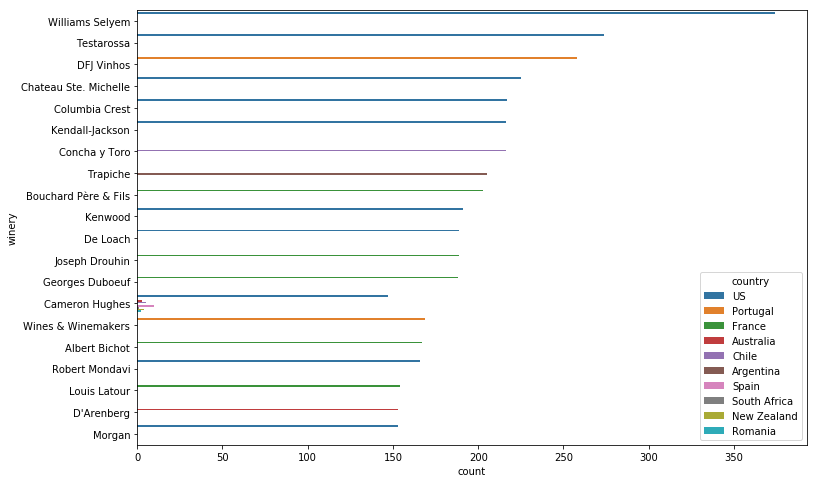

In [15]:
top20_wineries = df.winery.value_counts(normalize=True).nlargest(20) \
.sort_values(ascending= False).index

plt.figure(figsize=(12,8))
sns.countplot(y="winery", data=df[df.winery.isin(top20_wineries)],
              order=top20_wineries, hue="country")
plt.show()

US and France wineries get a lot of different wines.
Cameron Hughes winery is the only with wine produced all over the world.

 <a id="2"></a>
# 2) Zoom on the vineyard of France

In [16]:
french_df = df.loc[df["country"] == "France",:]
french_df.shape

(21098, 10)

<a id="2.1"></a>
## Which variety is the most expensive ?

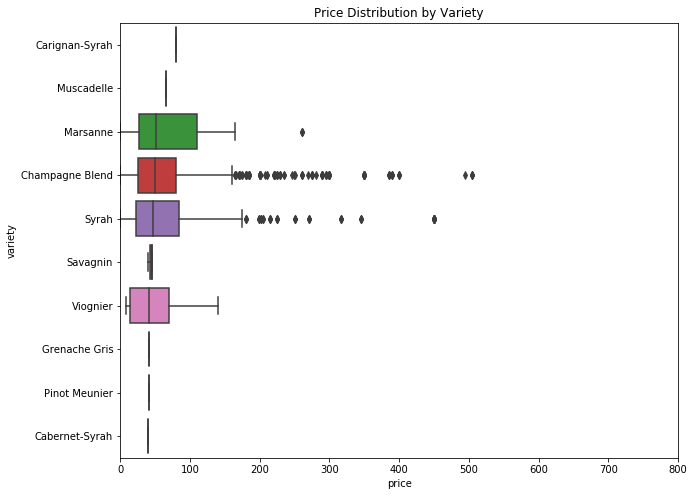

In [17]:
median_price_variety_fr = french_df.loc[:, ["variety", "price"]] \
         .groupby("variety") \
         .median() \
         .sort_values(by="price", ascending= False)      
median_price_top10_variety_fr = median_price_variety_fr.index[:10]

plt.figure(figsize=(10,8))
ax = sns.boxplot(x="price", y="variety",
                 data=french_df.loc[french_df["variety"].isin(median_price_top10_variety_fr),:],
                 order=median_price_top10_variety_fr
                )
plt.title("Price Distribution by Variety")
plt.xlim([0,800])
plt.show()

* **Carignan-Syrah** and **Muscadelle** has too few observations to say it's really an expensive variety.
* So **Marsanne** is the most expensive variety considering it's Median and it's InterQuartile Range. It's a white wine variety, not a famous variety, that's surprising !
* **Champagne** worldwide famous, associated to the French luxury, is not the most expensive as I thought. There is always an opportunity to drink champagne, as Lily Bollinger said - “I only drink champagne when I’m happy, and when I’m sad. Sometimes I drink it when I’m alone. When I have company, I consider it obligatory. I trifle with it if I am not hungry and drink it when I am. Otherwise I never touch it—unless I’m thirsty.” 

<a id="2.2"></a>
## Which variety has the best ratings for the most frequent variety ?

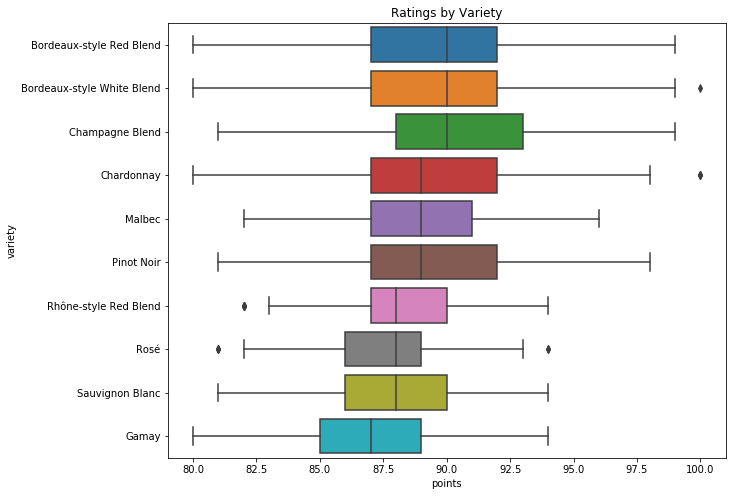

In [18]:
top10_variety_fr = french_df.variety.value_counts(normalize=True).nlargest(10) \
.sort_values(ascending= False).index
median_ratings_top10_variety_fr = french_df.loc[french_df["variety"]
         .isin(top10_variety_fr), ["variety", "points"]] \
         .groupby("variety") \
         .median() \
         .sort_values(by="points", ascending= False) \
         .index

plt.figure(figsize=(10,8))
ax = sns.boxplot(x="points", y="variety",
                 data=french_df.loc[french_df["variety"].isin(top10_variety_fr),:],
                 order=median_ratings_top10_variety_fr
                )
plt.title("Ratings by Variety")
plt.show()

Champagne, White and Read Bordeaux get the higghest ratings: 90.

Champagne ratings tends to be higher than others variety, the whisker is more
shifted to the right.

<a id="2.3"></a>
## Wineries with the biggest number of unique wines

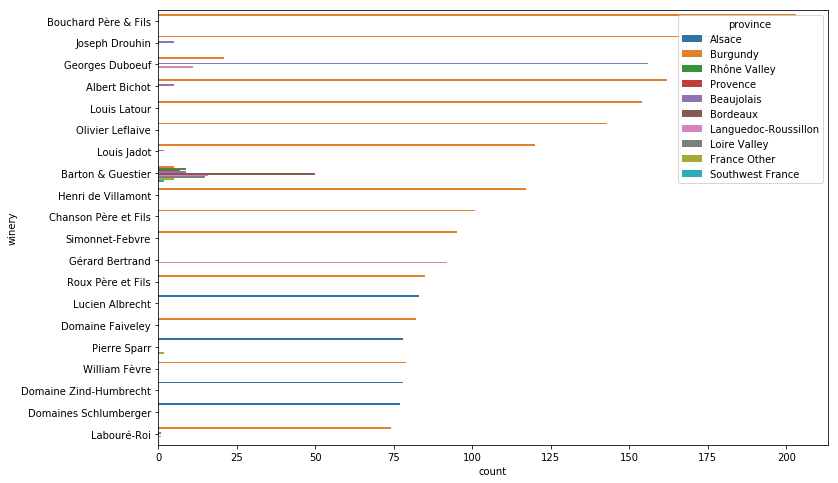

In [19]:
top20_wineries_fr = french_df.winery.value_counts(normalize=True).nlargest(20) \
.sort_values(ascending= False).index

plt.figure(figsize=(12,8))
sns.countplot(y="winery", data=french_df[french_df.winery.isin(top20_wineries_fr)],
              order=top20_wineries_fr, hue="province")
plt.show()

Burgundy (Bourgogne in French) is over represented, it came from the particularity of "climat" from this region.

A climat is a wine terroir, a small parcel of land with it's own particularities: climatic and geologic. There is more than 1000 different climat in Burgundy. 